# Lecture 9 - Graph Neural Networks

```{contents}
:local:
:depth: 1
```

## Learning goals

- Build an MLP in **PyTorch** from scratch: tensors, autograd, `Dataset`, `DataLoader`, training loop, validation loop, saving, loading.
- Explain molecules as graphs: atoms as nodes, bonds as edges, adjacency.
- Implement a minimal **message passing** layer.
- Convert SMILES to graph tensors and inspect shapes at each step.
- Train a small GNN for melting point regression and C–H reactivity classification.
- Run **Chemprop v2** for melting point and reactivity, then try toxicity as an in class activity.

---

## 1. PyTorch from zero to a working MLP

Students so far only used scikit-learn MLPs. Here we start PyTorch from the very beginning and keep every step visible. Each code cell is small. After each group of cells, you will get short exercises to tweak.

### 1.0 Setup

In [1]:
import warnings, math, os, sys, json, random
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# PyTorch
try:
    import torch
    import torch.nn as nn
    import torch.nn.functional as F
    from torch.utils.data import Dataset, DataLoader
except Exception:
    %pip install -q torch
    import torch
    import torch.nn as nn
    import torch.nn.functional as F
    from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (mean_squared_error, mean_absolute_error, r2_score,
                             accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, roc_auc_score, roc_curve)

plt.rcParams["figure.dpi"] = 120

### 1.1 Devices and seeds

In [2]:
# Pick device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
# Reproducibility helper
def set_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(0)

### 1.2 Tensors and gradients

In [4]:
# A tiny tensor demo
x = torch.tensor([[1.0, 2.0],
                  [3.0, 4.0]], requires_grad=True)
W = torch.tensor([[0.5],[ -1.0 ]], requires_grad=True)
b = torch.tensor([0.1], requires_grad=True)

y = x @ W + b        # shape [2,1]
loss = (y**2).mean() # simple scalar
loss.backward()

W.grad, b.grad, x.grad   # inspect gradients

(tensor([[ -8.6000],
         [-12.4000]]),
 tensor([-3.8000]),
 tensor([[-0.7000,  1.4000],
         [-1.2000,  2.4000]]))

**Idea**  
- `requires_grad=True` tells PyTorch to track ops on this tensor.  
- `loss.backward()` fills `.grad` for each leaf parameter.  
- `optimizer.step()` (next) will use `.grad` to update values.

### 1.3 A clean training step pattern

We prepare a toy regression and write a one epoch loop. This pattern repeats later for chemistry.

In [5]:
# Toy regression: y = sin(x) + noise
rng = np.random.RandomState(0)
X = np.linspace(-3, 3, 400).reshape(-1, 1)
y = np.sin(X) + 0.2 * rng.randn(*X.shape)

Xtr, Xval, ytr, yval = train_test_split(X, y, test_size=0.25, random_state=42)

# Scale inputs only
scaler = StandardScaler().fit(Xtr)
Xtr_s = scaler.transform(Xtr).astype(np.float32)
Xval_s = scaler.transform(Xval).astype(np.float32)
ytr_f  = ytr.astype(np.float32)
yval_f = yval.astype(np.float32)

Xtr_s[:3], ytr_f[:3]

(array([[ 0.39263156],
        [-0.81904864],
        [-1.6504204 ]], dtype=float32),
 array([[ 0.8710016 ],
        [-0.60129756],
        [-0.0741414 ]], dtype=float32))

In [6]:
# Simple dataset wrappers
class NumpyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float()
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.y[i]

train_ds = NumpyDataset(Xtr_s, ytr_f)
val_ds   = NumpyDataset(Xval_s, yval_f)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=128, shuffle=False)

In [7]:
# Define a tiny MLP for regression
class TinyMLP(nn.Module):
    def __init__(self, in_dim=1, hidden=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden), nn.ReLU(),
            nn.Linear(hidden, 1)
        )
    def forward(self, x):
        return self.net(x)

model = TinyMLP(in_dim=1, hidden=32).to(device)
loss_fn = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-3)

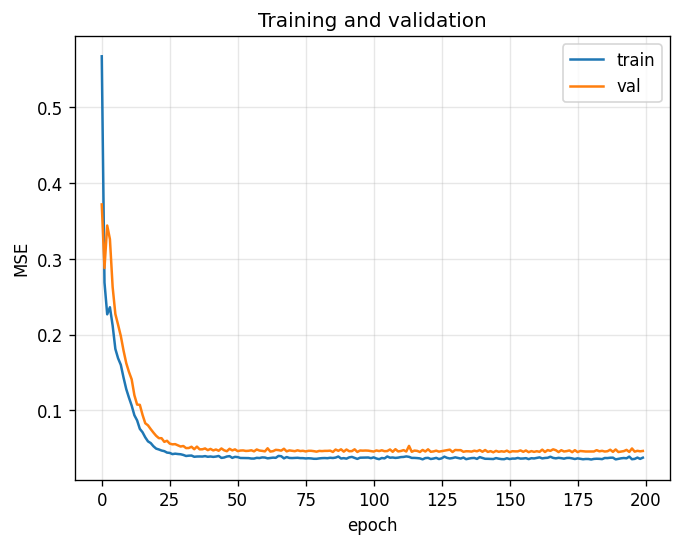

0.04463209956884384

In [8]:
# One full training loop with validation and best checkpoint
best_val = float("inf")
train_curve, val_curve = [], []

for epoch in range(200):
    # train
    model.train()
    batch_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        loss = loss_fn(pred, yb)
        opt.zero_grad(); loss.backward(); opt.step()
        batch_losses.append(loss.item())
    train_curve.append(np.mean(batch_losses))

    # validate
    model.eval()
    with torch.no_grad():
        v_losses = []
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            v_pred = model(xb)
            v_losses.append(loss_fn(v_pred, yb).item())
        val_m = float(np.mean(v_losses))
        val_curve.append(val_m)

    # early checkpoint
    if val_m < best_val:
        best_val = val_m
        torch.save({"model": model.state_dict()}, "tinymlp_best.pt")

plt.plot(train_curve, label="train"); plt.plot(val_curve, label="val")
plt.xlabel("epoch"); plt.ylabel("MSE"); plt.title("Training and validation"); plt.legend(); plt.grid(alpha=0.3)
plt.show()

best_val

MSE=0.0446  MAE=0.1740  R2=0.919


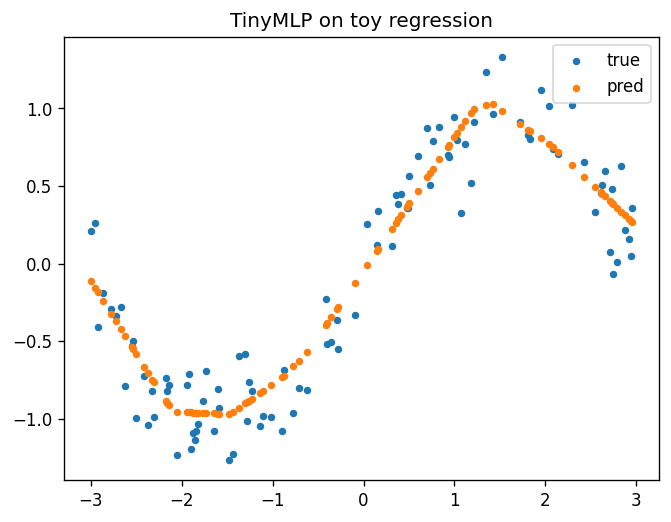

In [9]:
# Load best checkpoint and test on the validation grid for a figure
ckpt = torch.load("tinymlp_best.pt", map_location=device)
model.load_state_dict(ckpt["model"])
model.eval()
with torch.no_grad():
    yhat_val = model(torch.from_numpy(Xval_s).float().to(device)).cpu().numpy()

print(f"MSE={mean_squared_error(yval, yhat_val):.4f}  MAE={mean_absolute_error(yval, yhat_val):.4f}  R2={r2_score(yval, yhat_val):.3f}")

plt.scatter(Xval.ravel(), yval.ravel(), s=12, label="true")
plt.scatter(Xval.ravel(), yhat_val.ravel(), s=12, label="pred")
plt.title("TinyMLP on toy regression"); plt.legend(); plt.show()

```{admonition} Exercises 1A
1. Change `hidden=16` then `hidden=64`. Compare the best validation MSE.
2. Try `nn.Tanh()` instead of `nn.ReLU()`. Does the curve fit become smoother or worse here.
3. Increase `weight_decay` to `1e-2`. Watch for reduced overfitting on the curves.
```

### 1.4 A small classification example

We create a donut vs center dataset, train a classifier, then show the confusion matrix and ROC.

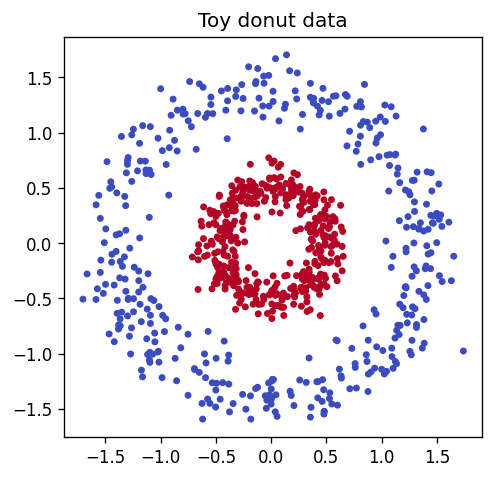

In [10]:
# Make 2-class toy data
rng = np.random.RandomState(1)
n = 400
theta = rng.uniform(0, 2*np.pi, n)
r_out = 1.4 + 0.15*rng.randn(n)
X_out = np.c_[r_out*np.cos(theta), r_out*np.sin(theta)]
y_out = np.zeros(n)

theta2 = rng.uniform(0, 2*np.pi, n)
r_in = 0.5 + 0.10*rng.randn(n)
X_in = np.c_[r_in*np.cos(theta2), r_in*np.sin(theta2)]
y_in = np.ones(n)

X2 = np.vstack([X_out, X_in]).astype(np.float32)
y2 = np.hstack([y_out, y_in]).astype(np.float32).reshape(-1,1)

plt.figure(figsize=(4.5,4.5))
plt.scatter(X2[:,0], X2[:,1], c=y2.ravel(), cmap="coolwarm", s=10)
plt.gca().set_aspect("equal"); plt.title("Toy donut data"); plt.show()

In [11]:
# Split and scale
Xtr, Xte, ytr, yte = train_test_split(X2, y2, test_size=0.25, random_state=42, stratify=y2)
sc = StandardScaler().fit(Xtr)
Xtr_s = sc.transform(Xtr).astype(np.float32)
Xte_s = sc.transform(Xte).astype(np.float32)

train_loader = DataLoader(NumpyDataset(Xtr_s, ytr), batch_size=64, shuffle=True)
test_loader  = DataLoader(NumpyDataset(Xte_s, yte), batch_size=128, shuffle=False)

In [12]:
# Classifier MLP
class TinyClassifier(nn.Module):
    def __init__(self, in_dim=2, hidden=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden), nn.ReLU(),
            nn.Linear(hidden, 1)
        )
    def forward(self, x):
        return self.net(x)  # logits

clf = TinyClassifier(in_dim=2, hidden=32).to(device)
loss_fn = nn.BCEWithLogitsLoss()
opt = torch.optim.Adam(clf.parameters(), lr=5e-3, weight_decay=1e-3)

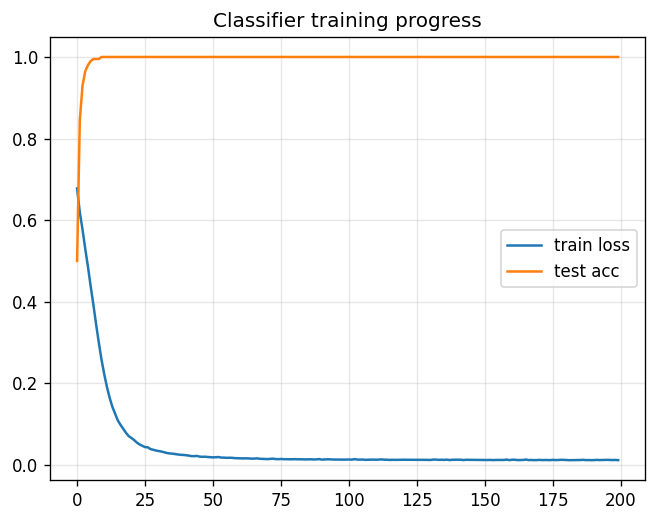

In [13]:
# Train for 200 epochs and track accuracy
train_curve, val_curve = [], []
for epoch in range(200):
    clf.train(); batch_losses=[]
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        logit = clf(xb)
        loss = loss_fn(logit, yb)
        opt.zero_grad(); loss.backward(); opt.step()
        batch_losses.append(loss.item())
    train_curve.append(np.mean(batch_losses))

    # quick accuracy on test as validation proxy
    clf.eval()
    with torch.no_grad():
        all_logit, all_y = [], []
        for xb, yb in test_loader:
            xb = xb.to(device)
            all_logit.append(clf(xb).cpu())
            all_y.append(yb)
        logit = torch.cat(all_logit).numpy().ravel()
        ytrue = torch.cat(all_y).numpy().ravel().astype(int)
        proba = 1/(1+np.exp(-logit))
        pred = (proba >= 0.5).astype(int)
        val_curve.append(accuracy_score(ytrue, pred))

plt.plot(train_curve, label="train loss"); plt.plot(val_curve, label="test acc")
plt.legend(); plt.title("Classifier training progress"); plt.grid(alpha=0.3); plt.show()

ACC=1.000  PREC=1.000  REC=1.000  F1=1.000  AUC=1.000


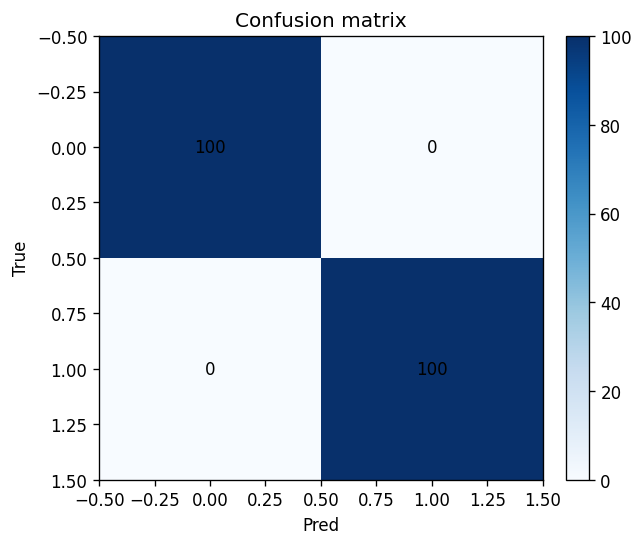

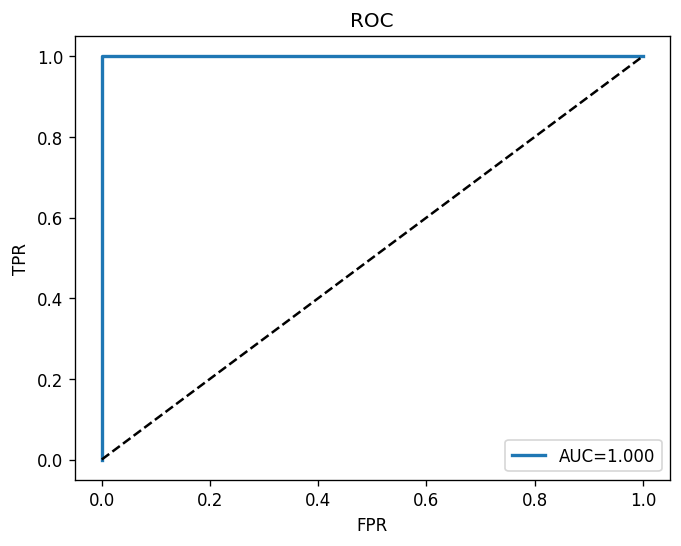

In [14]:
# Final metrics and plots
from sklearn.metrics import confusion_matrix

proba = []
ytrue = []
clf.eval()
with torch.no_grad():
    for xb, yb in test_loader:
        p = torch.sigmoid(clf(xb.to(device))).cpu().numpy()
        proba.append(p); ytrue.append(yb.numpy())
proba = np.vstack(proba).ravel()
yt = np.vstack(ytrue).ravel().astype(int)

pred = (proba >= 0.5).astype(int)
acc  = accuracy_score(yt, pred)
prec = precision_score(yt, pred)
rec  = recall_score(yt, pred)
f1   = f1_score(yt, pred)
auc  = roc_auc_score(yt, proba)
print(f"ACC={acc:.3f}  PREC={prec:.3f}  REC={rec:.3f}  F1={f1:.3f}  AUC={auc:.3f}")

cm = confusion_matrix(yt, pred)
plt.imshow(cm, cmap="Blues")
plt.title("Confusion matrix"); plt.xlabel("Pred"); plt.ylabel("True")
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i,j], ha="center", va="center")
plt.colorbar(fraction=0.046, pad=0.04); plt.show()

fpr, tpr, thr = roc_curve(yt, proba)
plt.plot(fpr, tpr, lw=2, label=f"AUC={auc:.3f}")
plt.plot([0,1],[0,1],"k--")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC"); plt.legend(); plt.show()

```{admonition} Exercises 1B
1. Try hidden sizes 16 and 64. Compare AUC.
2. Replace `ReLU` with `Tanh`. Does the donut boundary change.
3. Print metrics at thresholds `0.3` and `0.7`. Which threshold gives higher recall.
```

```{admonition} Tip
Save your best model with `torch.save` and load with `torch.load`. We already used this flow above for regression.
```

---

## 2. From scikit-learn to PyTorch: mapping the parts

- scikit-learn pipeline wrapped scaling and the model.  
- In PyTorch we wrote `StandardScaler` ourselves, then a `Dataset`, then a model.  
- `fit` in scikit-learn equals our loop: forward, loss, backward, step.

Small checklist you can reuse in any project:

```{admonition} Training checklist
1. Split train and test.  
2. Scale inputs if needed.  
3. Wrap arrays in `Dataset` and `DataLoader`.  
4. Define model, loss, optimizer.  
5. Loop over epochs and batches.  
6. Track train loss and a validation metric.  
7. Save the best checkpoint.  
8. Evaluate on the held out test split.
```

---

## 3. Molecules as graphs and the idea of message passing

A molecule is a graph:
- Nodes are atoms with features such as atomic number or aromatic flag.
- Edges are bonds. You can add edge features like bond order.

A message passing layer for node `i`:

\[\n\mathbf{m}_i = \sum_{j \in \mathcal{N}(i)} \phi(\mathbf{h}_j), \quad\n\mathbf{h}'_i = \psi(\mathbf{h}_i, \mathbf{m}_i)\n\]

We start with the simplest case with no edge features and sum aggregation.

---

## 4. A minimal message passing layer on a toy graph

### 4.1 Toy graph tensors

In [15]:
import torch

edge_index = torch.tensor([[0,1,2,2,3,1],
                           [1,0,1,3,2,2]], dtype=torch.long)  # [2, E]
x = torch.tensor([[1.,0.,0.],
                  [0.,1.,0.],
                  [0.,0.,1.],
                  [1.,1.,0.]], dtype=torch.float32)          # [N, F]

edge_index.shape, x.shape

(torch.Size([2, 6]), torch.Size([4, 3]))

### 4.2 One message passing layer

In [16]:
class MPConv(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.msg = nn.Sequential(nn.Linear(in_dim, out_dim), nn.ReLU())
        self.update = nn.Sequential(nn.Linear(in_dim + out_dim, out_dim), nn.ReLU())
    def forward(self, x, edge_index):
        src, dst = edge_index
        m = self.msg(x[src])                    # [E, out_dim]
        agg = torch.zeros(x.size(0), m.size(1))
        agg.index_add_(0, dst, m)               # sum by destinations
        h_cat = torch.cat([x, agg], dim=1)
        return self.update(h_cat)

layer = MPConv(3, 8)
h1 = layer(x, edge_index)
h1.shape

torch.Size([4, 8])

```{admonition} Exercise 4.1
Switch to mean aggregation. Count in-degree per node with `torch.bincount(dst)`, divide `agg` by the degree.
```

---

## 5. From SMILES to graph tensors

We need a featurizer to convert each SMILES into node features and edges.

In [17]:
# RDKit optional
try:
    from rdkit import Chem
    from rdkit.Chem import rdchem
except Exception:
    Chem = None

### 5.1 Node features

In [18]:
ATOM_LIST = [1, 6, 7, 8, 9, 16, 17, 35, 53]  # H C N O F S Cl Br I

def atom_features(atom):
    Z = atom.GetAtomicNum()
    onehot = [(1.0 if Z == z else 0.0) for z in ATOM_LIST]
    aromatic = [1.0 if atom.GetIsAromatic() else 0.0]
    return np.array(onehot + aromatic, dtype=np.float32)

def smiles_to_graph(smiles):
    if Chem is None:
        x = torch.tensor([[1.0]+[0.0]*9,
                          [0.0,1.0]+[0.0]*8,
                          [0.0,0.0,1.0]+[0.0]*7], dtype=torch.float32)
        ei = torch.tensor([[0,1,1,2],[1,0,2,1]], dtype=torch.long)
        return x, ei
    mol = Chem.MolFromSmiles(smiles)
    xs, edges = [], []
    for a in mol.GetAtoms():
        xs.append(atom_features(a))
    for b in mol.GetBonds():
        u, v = b.GetBeginAtomIdx(), b.GetEndAtomIdx()
        edges += [[u,v],[v,u]]
    x = torch.from_numpy(np.vstack(xs)).float()
    ei = torch.tensor(np.array(edges).T, dtype=torch.long) if edges else torch.zeros((2,0), dtype=torch.long)
    return x, ei

for s in ["CCO", "c1ccccc1", "CC(=O)O"]:
    xg, eg = smiles_to_graph(s)
    print(s, "-> x", tuple(xg.shape), "ei", tuple(eg.shape))

CCO -> x (3, 10) ei (2, 4)
c1ccccc1 -> x (6, 10) ei (2, 12)
CC(=O)O -> x (4, 10) ei (2, 6)


```{admonition} Exercise 5.1
Add atom degree as an extra one hot of size 5 for degrees 0 to 4. Print the new feature dimension.
```

### 5.2 Batching variable size graphs

In [19]:
def collate_graphs(graph_list):
    xs, eis, batch_ids = [], [], []
    offset = 0
    for gid, (x, ei) in enumerate(graph_list):
        xs.append(x)
        if ei.numel(): eis.append(ei + offset)
        batch_ids.append(torch.full((x.size(0),), gid, dtype=torch.long))
        offset += x.size(0)
    X = torch.cat(xs, dim=0)
    EI = torch.cat(eis, dim=1) if len(eis) else torch.zeros((2,0), dtype=torch.long)
    BID = torch.cat(batch_ids, dim=0)
    return X, EI, BID

graphs = [smiles_to_graph(s) for s in ["CCO","c1ccccc1","CC(=O)O"]]
X, EI, BID = collate_graphs(graphs)
X.shape, EI.shape, BID.shape, int(BID.max().item())+1

(torch.Size([13, 10]), torch.Size([2, 22]), torch.Size([13]), 3)

```{admonition} Exercise 5.2
Verify that `EI.max() < X.size(0)` and `EI.min() >= 0` after batching.
```

---

## 6. Minimal GNN for melting point regression

We will use the course dataset. The goal is a working end to end GNN with clear shapes.

In [20]:
url = "https://raw.githubusercontent.com/zzhenglab/ai4chem/main/book/_data/C_H_oxidation_dataset.csv"
df_raw = pd.read_csv(url)
df_mp = df_raw[["SMILES","Melting Point"]].dropna().reset_index(drop=True)
df_mp.head(3)

,SMILES,Melting Point
0,c1ccc2c(c1)CCOC2,65.8
1,c1ccc2c(c1)Cc1ccccc1-2,90.0
2,c1ccc2c(c1)CCCC2,69.4


### 6.1 Dataset and collate

In [21]:
class MolGraphDataset(Dataset):
    def __init__(self, smiles, y=None):
        self.smiles = smiles
        self.y = None if y is None else y.astype(np.float32).reshape(-1,1)
    def __len__(self): return len(self.smiles)
    def __getitem__(self, i):
        x, ei = smiles_to_graph(self.smiles[i])
        if self.y is None: return (x, ei), None
        return (x, ei), torch.from_numpy(self.y[i])

def mp_collate(batch):
    graphs, targets = zip(*batch)
    X, EI, BID = collate_graphs(graphs)
    y = None if targets[0] is None else torch.stack(targets)
    return (X.float(), EI.long(), BID.long()), y

### 6.2 Model and training

In [22]:
class TinyGNN(nn.Module):
    def __init__(self, in_dim, hidden=64, out_dim=64):
        super().__init__()
        self.conv1 = MPConv(in_dim, hidden)
        self.conv2 = MPConv(hidden, hidden)
        self.proj  = nn.Linear(hidden, out_dim)
    def forward(self, x, ei, bid):
        h = self.conv1(x, ei); h = self.conv2(h, ei)
        # mean pool by graph
        n = int(bid.max().item()) + 1
        hg = torch.zeros(n, h.size(1))
        hg.index_add_(0, bid, h)
        cnt = torch.bincount(bid, minlength=n).clamp(min=1).view(-1,1)
        hg = hg / cnt
        return self.proj(hg)

class GNNRegressor(nn.Module):
    def __init__(self, in_dim, hidden=64):
        super().__init__()
        self.gnn = TinyGNN(in_dim, hidden, hidden)
        self.head = nn.Sequential(nn.Linear(hidden, hidden), nn.ReLU(), nn.Linear(hidden,1))
    def forward(self, X, EI, BID):
        return self.head(self.gnn(X, EI, BID))

In [23]:
smiles = df_mp["SMILES"].values
y = df_mp["Melting Point"].values
sm_tr, sm_te, y_tr, y_te = train_test_split(smiles, y, test_size=0.2, random_state=15)

train_ds = MolGraphDataset(sm_tr, y_tr)
test_ds  = MolGraphDataset(sm_te, y_te)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,  collate_fn=mp_collate)
test_loader  = DataLoader(test_ds,  batch_size=64, shuffle=False, collate_fn=mp_collate)

# infer in_dim
(Xb, EIb, BIDb), yb = next(iter(train_loader))
in_dim = Xb.size(1)

reg = GNNRegressor(in_dim=in_dim, hidden=64)
opt = torch.optim.Adam(reg.parameters(), lr=1e-3, weight_decay=1e-3)
loss_fn = nn.MSELoss()

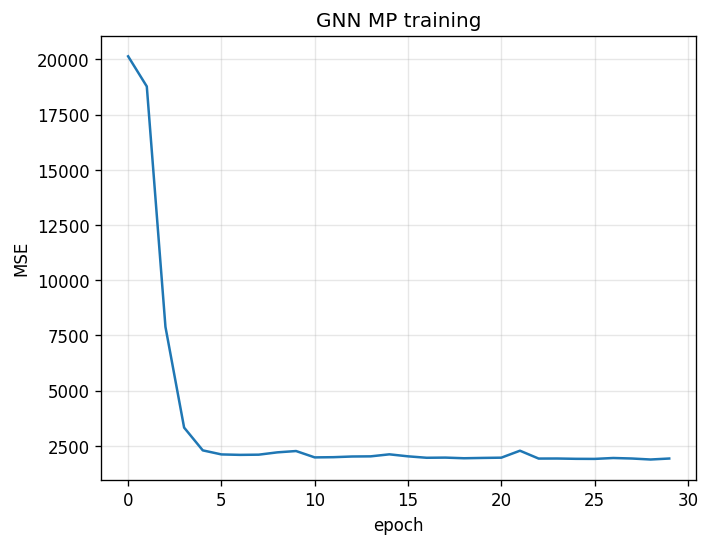

In [24]:
# Train 30 epochs
train_curve = []
for epoch in range(30):
    reg.train(); batch_losses=[]
    for (Xb, EIb, BIDb), yb in train_loader:
        pred = reg(Xb, EIb, BIDb)
        loss = loss_fn(pred, yb)
        opt.zero_grad(); loss.backward(); opt.step()
        batch_losses.append(loss.item())
    train_curve.append(np.mean(batch_losses))

plt.plot(train_curve); plt.xlabel("epoch"); plt.ylabel("MSE"); plt.title("GNN MP training"); plt.grid(alpha=0.3); plt.show()

MSE=1580.81  MAE=29.53  R2=0.257


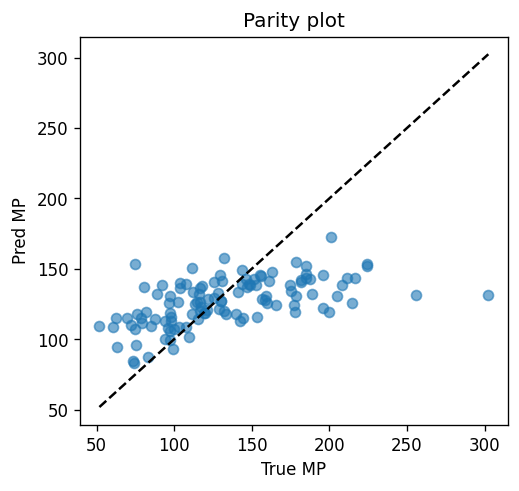

In [25]:
# Evaluate
reg.eval()
yh, yt = [], []
with torch.no_grad():
    for (Xb, EIb, BIDb), yb in test_loader:
        yh.append(reg(Xb, EIb, BIDb).cpu().numpy()); yt.append(yb.cpu().numpy())
yhat = np.vstack(yh); ytrue = np.vstack(yt)

print(f"MSE={mean_squared_error(ytrue, yhat):.2f}  MAE={mean_absolute_error(ytrue, yhat):.2f}  R2={r2_score(ytrue, yhat):.3f}")

plt.figure(figsize=(4.6,4.2))
plt.scatter(ytrue, yhat, alpha=0.6)
lims = [min(ytrue.min(), yhat.min()), max(ytrue.max(), yhat.max())]
plt.plot(lims, lims, "k--"); plt.xlabel("True MP"); plt.ylabel("Pred MP"); plt.title("Parity plot"); plt.show()

```{admonition} Exercise 6.1
Change `hidden` from 64 to 128 and train again for 30 epochs. Did R² increase. If not, why might that happen on small data.
```

---

## 7. Minimal GNN for C–H reactivity classification

We will binarize reactivity: map `-1` to `0`, others to `1`.

In [26]:
df_rxn = df_raw[["SMILES","Reactivity"]].dropna().copy()
df_rxn["Reactivity_bin"] = df_rxn["Reactivity"].replace({-1:0}).astype(int)
df_rxn["Reactivity_bin"].value_counts()

Reactivity_bin
0    311
1    264
Name: count, dtype: int64

### 7.1 Dataset and model

In [27]:
class GNNClassifier(nn.Module):
    def __init__(self, in_dim, hidden=64):
        super().__init__()
        self.gnn = TinyGNN(in_dim, hidden, hidden)
        self.head = nn.Sequential(nn.Linear(hidden, hidden), nn.ReLU(), nn.Linear(hidden,1))
    def forward(self, X, EI, BID):
        return self.head(self.gnn(X, EI, BID))  # logits

In [28]:
sm = df_rxn["SMILES"].values
y  = df_rxn["Reactivity_bin"].values.astype(np.float32).reshape(-1,1)
sm_tr, sm_te, y_tr, y_te = train_test_split(sm, y, test_size=0.2, random_state=42, stratify=y)

train_ds = MolGraphDataset(sm_tr, y_tr)
test_ds  = MolGraphDataset(sm_te, y_te)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, collate_fn=mp_collate)
test_loader  = DataLoader(test_ds,  batch_size=128, shuffle=False, collate_fn=mp_collate)

# infer input dim
(Xb, EIb, BIDb), yb = next(iter(train_loader))
in_dim = Xb.size(1)

clf = GNNClassifier(in_dim=in_dim, hidden=64)
opt = torch.optim.Adam(clf.parameters(), lr=1e-3, weight_decay=1e-3)
loss_fn = nn.BCEWithLogitsLoss()

### 7.2 Train and evaluate

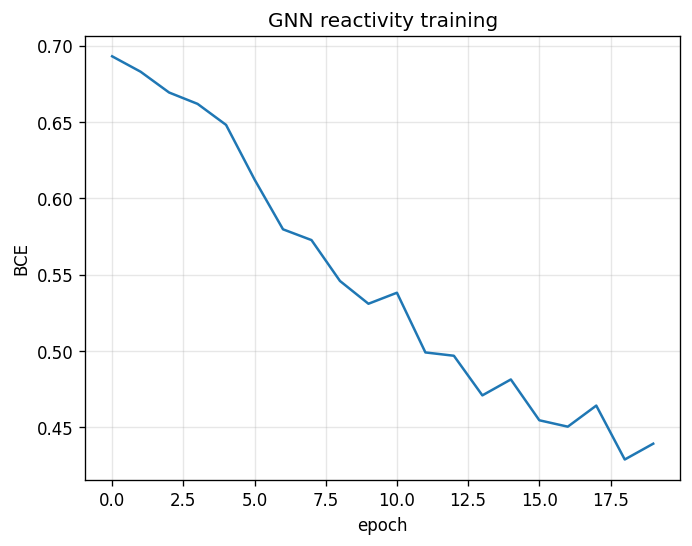

In [29]:
losses = []
for epoch in range(20):
    clf.train(); bl=[]
    for (Xb, EIb, BIDb), yb in train_loader:
        logit = clf(Xb, EIb, BIDb)
        loss = loss_fn(logit, yb)
        opt.zero_grad(); loss.backward(); opt.step()
        bl.append(loss.item())
    losses.append(np.mean(bl))

plt.plot(losses); plt.xlabel("epoch"); plt.ylabel("BCE"); plt.title("GNN reactivity training"); plt.grid(alpha=0.3); plt.show()

ACC=0.809  PREC=0.782  REC=0.811  F1=0.796  AUC=0.896


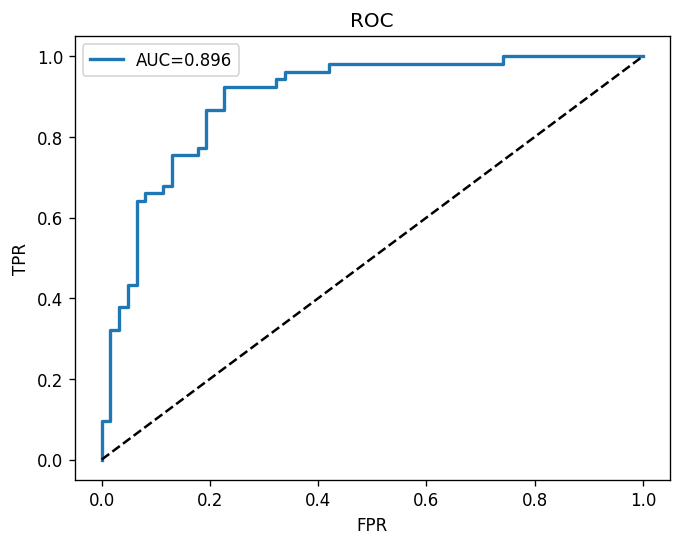

In [30]:
# Metrics
clf.eval()
probs, labs = [], []
with torch.no_grad():
    for (Xb, EIb, BIDb), yb in test_loader:
        p = torch.sigmoid(clf(Xb, EIb, BIDb)).cpu().numpy()
        probs.append(p); labs.append(yb.cpu().numpy())
proba = np.vstack(probs).ravel()
yt = np.vstack(labs).ravel().astype(int)

pred = (proba >= 0.5).astype(int)
acc  = accuracy_score(yt, pred)
prec = precision_score(yt, pred)
rec  = recall_score(yt, pred)
f1   = f1_score(yt, pred)
auc  = roc_auc_score(yt, proba)
print(f"ACC={acc:.3f}  PREC={prec:.3f}  REC={rec:.3f}  F1={f1:.3f}  AUC={auc:.3f}")

fpr, tpr, thr = roc_curve(yt, proba)
plt.plot(fpr, tpr, lw=2, label=f"AUC={auc:.3f}"); plt.plot([0,1],[0,1],"k--")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC"); plt.legend(); plt.show()

```{admonition} Exercise 7.1
Print metrics at thresholds `0.3`, `0.5`, `0.7`. Which threshold gives the best F1 on this split.
```

---

## 8. Chemprop v2 quickstarts

Chemprop provides a production model for molecular graphs. We try two tasks with the same dataset.

### 8.1 Install Chemprop v2

In [31]:
%pip install -q chemprop
import pandas as pd

^C


Note: you may need to restart the kernel to use updated packages.


### 8.2 Melting point regression with Chemprop

In [ ]:
url = "https://raw.githubusercontent.com/zzhenglab/ai4chem/main/book/_data/C_H_oxidation_dataset.csv"
df = pd.read_csv(url)
df_mp = df[["SMILES","Melting Point"]].dropna().rename(columns={"Melting Point":"MP"})
df_mp.to_csv("mp_data.csv", index=False)
df_mp.head(3)

In [ ]:
!chemprop train \
  --data-path mp_data.csv \
  -t regression \
  -s SMILES \
  --target-columns MP \
  -o mp_model \
  --num-replicates 2 \
  --epochs 15 \
  --metrics rmse mae r2 \
  --tracking-metric rmse

In [ ]:
smiles_list = ["CCO", "c1ccccc1", "CC(=O)O", "O=C(O)C(O)C(O)C(O)CO"]
pd.DataFrame({"SMILES": smiles_list}).to_csv("custom_smiles.csv", index=False)

!chemprop predict \
  --test-path custom_smiles.csv \
  --model-paths mp_model/replicate_0/model_0/best.pt \
  --preds-path mp_preds.csv

pd.read_csv("mp_preds.csv")

### 8.3 Reactivity classification with Chemprop

In [ ]:
df = pd.read_csv(url)
df["Reactivity_bin"] = df["Reactivity"].replace({-1: 0}).astype(int)
df[["SMILES","Reactivity_bin"]].to_csv("reactivity_data_bin.csv", index=False)

df["Reactivity"].value_counts(dropna=False).to_dict(), df["Reactivity_bin"].value_counts(dropna=False).to_dict()

In [ ]:
!chemprop train \
  --data-path reactivity_data_bin.csv \
  -t classification \
  -s SMILES \
  --target-columns Reactivity_bin \
  -o reactivity_model \
  --num-replicates 3 \
  --epochs 15 \
  --class-balance \
  --metrics roc prc accuracy \
  --tracking-metric roc

In [ ]:
smiles_list = [
    "CCO",
    "c1ccccc1C(F)",
    "C1=C([C@@H]2C[C@H](C1)C2(C)C)C",
    "C1=CC=CC=C1C=O",
    "CCN(CC)CC",
    "c1cccc(C=CC)c1"
]
pd.DataFrame({"SMILES": smiles_list}).to_csv("custom_smiles.csv", index=False)

!chemprop predict \
  --test-path custom_smiles.csv \
  --model-paths reactivity_model/replicate_0/model_0/best.pt \
  --preds-path custom_preds.csv

pd.read_csv("custom_preds.csv")

```{admonition} Exercise 8.1
Create `tox.csv` with `SMILES,Toxic_bin` where `Toxicity` maps to 1 for "toxic" and 0 for "non_toxic". Train `chemprop train` for 10 epochs and report ROC AUC.
```

---

## 9. Glossary and references

```{glossary}
autograd
  PyTorch system that records ops on tensors with `requires_grad=True` and computes gradients.

Dataset
  Python object that returns items by index. Works with `DataLoader` to create batches.

message passing
  For each node, aggregate transformed neighbor features, then update the node state.

edge index
  A two row tensor listing directed edges as source and destination indices.

readout
  Pooling step that turns node states into one graph vector. Mean or sum are common.

Chemprop
  A library and CLI for molecular property prediction with graph models.
```

**References**

- Gilmer et al., Neural Message Passing for Quantum Chemistry, ICML 2017.  
- Battaglia et al., Relational inductive biases, deep learning, and graph networks, 2018.  
- PyTorch docs for Tensor, Module, Optim, and Data.  
- Chemprop documentation and examples.

---

## 10. In class activity and solutions

Try first. Solutions follow each question in a hidden tagged cell.

### Q1. MLP regression early stopping

- Use the Section 1.3 toy regression.
- Implement simple early stopping: stop if validation MSE does not improve for 20 epochs.
- Plot the training curve up to the stop point.

```python
# YOUR TURN
```

In [ ]:
# Solution Q1
set_seed(0)
model = TinyMLP(1, 32)
opt = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-3)
loss_fn = nn.MSELoss()
best = float("inf"); patience, wait = 20, 0
train_curve = []; val_curve = []

for epoch in range(1000):
    model.train(); bl=[]
    for xb, yb in DataLoader(NumpyDataset(Xtr_s, ytr_f), batch_size=64, shuffle=True):
        pred = model(xb); loss = loss_fn(pred, yb)
        opt.zero_grad(); loss.backward(); opt.step()
        bl.append(loss.item())
    train_curve.append(np.mean(bl))

    model.eval()
    with torch.no_grad():
        vpred = model(torch.from_numpy(Xval_s)).numpy()
        v = mean_squared_error(yval, vpred)
    val_curve.append(v)

    if v < best:
        best = v; wait = 0
    else:
        wait += 1
        if wait >= patience:
            break

len(train_curve), best

### Q2. Mean aggregation in MPConv

- Replace sum with mean in Section 4.2.
- Refit melting point GNN for 30 epochs.
- Compare R².

```python
# YOUR TURN
```

In [ ]:
# Solution Q2
class MPConvMean(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.msg = nn.Sequential(nn.Linear(in_dim, out_dim), nn.ReLU())
        self.update = nn.Sequential(nn.Linear(in_dim + out_dim, out_dim), nn.ReLU())
    def forward(self, x, ei):
        src, dst = ei
        m = self.msg(x[src])
        agg = torch.zeros(x.size(0), m.size(1))
        agg.index_add_(0, dst, m)
        deg = torch.bincount(dst, minlength=x.size(0)).clamp(min=1).view(-1,1)
        agg = agg / deg
        return self.update(torch.cat([x, agg], dim=1))

class TinyGNNMean(nn.Module):
    def __init__(self, in_dim, hidden=64):
        super().__init__()
        self.c1 = MPConvMean(in_dim, hidden)
        self.c2 = MPConvMean(hidden, hidden)
        self.proj = nn.Linear(hidden, hidden)
    def forward(self, x, ei, bid):
        h = self.c1(x, ei); h = self.c2(h, ei)
        n = int(bid.max().item()) + 1
        hg = torch.zeros(n, h.size(1))
        hg.index_add_(0, bid, h)
        cnt = torch.bincount(bid, minlength=n).clamp(min=1).view(-1,1)
        return self.proj(hg / cnt)

# quick run
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, collate_fn=mp_collate)
test_loader  = DataLoader(test_ds,  batch_size=64, shuffle=False, collate_fn=mp_collate)
(Xb, EIb, BIDb), yb = next(iter(train_loader)); in_dim = Xb.size(1)

gnn = TinyGNNMean(in_dim, 64)
head = nn.Sequential(nn.Linear(64,64), nn.ReLU(), nn.Linear(64,1))
params = list(gnn.parameters()) + list(head.parameters())
opt = torch.optim.Adam(params, lr=1e-3, weight_decay=1e-3)
loss_fn = nn.MSELoss()

for epoch in range(20):
    for (Xb, EIb, BIDb), yb in train_loader:
        pred = head(gnn(Xb, EIb, BIDb))
        loss = loss_fn(pred, yb)
        opt.zero_grad(); loss.backward(); opt.step()

gnn.eval(); head.eval()
yh, yt = [], []
with torch.no_grad():
    for (Xb, EIb, BIDb), yb in test_loader:
        yh.append(head(gnn(Xb, EIb, BIDb)).numpy()); yt.append(yb.numpy())
yh = np.vstack(yh); yt = np.vstack(yt)
print("R2 mean agg:", r2_score(yt, yh))

### Q3. Add bond order as edge feature

- If RDKit is available, one hot encode bond type with 4 bins.
- Concatenate edge features to source node features inside the message MLP.
- Train reactivity for 10 epochs and print AUC.

```python
# YOUR TURN
```

In [ ]:
BONDS = [rdchem.BondType.SINGLE, rdchem.BondType.DOUBLE, rdchem.BondType.TRIPLE, rdchem.BondType.AROMATIC] if Chem else []

def smiles_to_graph_edges(smiles):
    if Chem is None:
        x = torch.eye(len(ATOM_LIST)+1)[:3]
        ei = torch.tensor([[0,1,1,2],[1,0,2,1]], dtype=torch.long)
        ef = torch.zeros((ei.size(1), 4))
        return x.float(), ei, ef.float()
    mol = Chem.MolFromSmiles(smiles)
    xs, edges, efs = [], [], []
    for a in mol.GetAtoms():
        xs.append(atom_features(a))
    for b in mol.GetBonds():
        u, v = b.GetBeginAtomIdx(), b.GetEndAtomIdx()
        k = BONDS.index(b.GetBondType()) if b.GetBondType() in BONDS else 0
        oh = np.zeros(4, dtype=np.float32); oh[k] = 1.0
        edges += [[u,v],[v,u]]; efs += [oh, oh]
    x = torch.from_numpy(np.vstack(xs)).float()
    ei = torch.tensor(np.array(edges).T, dtype=torch.long) if edges else torch.zeros((2,0), dtype=torch.long)
    ef = torch.from_numpy(np.vstack(efs)).float() if efs else torch.zeros((0,4), dtype=torch.float32)
    return x, ei, ef

def collate_graphs_with_edges(graphs):
    xs, eis, efs, bids = [], [], [], []
    off = 0
    for gid, (x, ei, ef) in enumerate(graphs):
        xs.append(x)
        if ei.numel():
            eis.append(ei + off); efs.append(ef)
        bids.append(torch.full((x.size(0),), gid, dtype=torch.long))
        off += x.size(0)
    X = torch.cat(xs, 0)
    EI = torch.cat(eis, 1) if eis else torch.zeros((2,0), dtype=torch.long)
    EF = torch.cat(efs, 0) if efs else torch.zeros((0,4), dtype=torch.float32)
    BID = torch.cat(bids, 0)
    return X, EI, EF, BID

class MPConvEdge(nn.Module):
    def __init__(self, in_dim, edge_dim, out_dim):
        super().__init__()
        self.msg = nn.Sequential(nn.Linear(in_dim+edge_dim, out_dim), nn.ReLU())
        self.update = nn.Sequential(nn.Linear(in_dim+out_dim, out_dim), nn.ReLU())
    def forward(self, x, ei, ef):
        if ei.numel() == 0:
            agg = torch.zeros(x.size(0), self.msg[0].out_features)
            return self.update(torch.cat([x, agg], dim=1))
        src, dst = ei
        m = self.msg(torch.cat([x[src], ef], dim=1))
        agg = torch.zeros(x.size(0), m.size(1))
        agg.index_add_(0, dst, m)
        return self.update(torch.cat([x, agg], dim=1))

class TinyGNNEdge(nn.Module):
    def __init__(self, in_dim, edge_dim, hidden=64):
        super().__init__()
        self.c1 = MPConvEdge(in_dim, edge_dim, hidden)
        self.c2 = MPConvEdge(hidden, edge_dim, hidden)
    def forward(self, x, ei, ef, bid):
        h = self.c1(x, ei, ef); h = self.c2(h, ei, ef)
        n = int(bid.max().item()) + 1
        hg = torch.zeros(n, h.size(1))
        hg.index_add_(0, bid, h)
        cnt = torch.bincount(bid, minlength=n).clamp(min=1).view(-1,1)
        return hg / cnt

# Build datasets
class RxnDataset(Dataset):
    def __init__(self, smiles, y):
        self.smiles = smiles; self.y = y.astype(np.float32).reshape(-1,1)
    def __len__(self): return len(self.smiles)
    def __getitem__(self, i):
        x, ei, ef = smiles_to_graph_edges(self.smiles[i])
        return (x, ei, ef), torch.from_numpy(self.y[i])

def rxn_collate(batch):
    graphs, ys = zip(*batch)
    X, EI, EF, BID = collate_graphs_with_edges(graphs)
    return (X.float(), EI.long(), EF.float(), BID.long()), torch.stack(ys)

sm = df_rxn["SMILES"].values
y  = df_rxn["Reactivity_bin"].values
sm_tr, sm_te, y_tr, y_te = train_test_split(sm, y, test_size=0.2, random_state=42, stratify=y)

train_loader = DataLoader(RxnDataset(sm_tr, y_tr), batch_size=64, shuffle=True, collate_fn=rxn_collate)
test_loader  = DataLoader(RxnDataset(sm_te, y_te), batch_size=128, shuffle=False, collate_fn=rxn_collate)

(Xb, EIb, EFb, BIDb), yb = next(iter(train_loader))
in_dim, edge_dim = Xb.size(1), EFb.size(1)

gnn = TinyGNNEdge(in_dim, edge_dim, hidden=64)
head = nn.Linear(64, 1)
opt = torch.optim.Adam(list(gnn.parameters())+list(head.parameters()), lr=1e-3, weight_decay=1e-3)
loss_fn = nn.BCEWithLogitsLoss()

for epoch in range(10):
    for (Xb, EIb, EFb, BIDb), yb in train_loader:
        logit = head(gnn(Xb, EIb, EFb, BIDb))
        loss = loss_fn(logit, yb)
        opt.zero_grad(); loss.backward(); opt.step()

# AUC
gnn.eval(); head.eval()
probs, labs = [], []
with torch.no_grad():
    for (Xb, EIb, EFb, BIDb), yb in test_loader:
        probs.append(torch.sigmoid(head(gnn(Xb, EIb, EFb, BIDb))).numpy())
        labs.append(yb.numpy())
proba = np.vstack(probs).ravel(); yt = np.vstack(labs).ravel().astype(int)
print("AUC with bond features:", roc_auc_score(yt, proba))

### Q4. Chemprop toxicity

- Build `tox.csv` with `SMILES,Toxic_bin`.
- Train 10 epochs and report ROC AUC.

```python
# YOUR TURN
```

In [ ]:
df = pd.read_csv(url)
tox = pd.DataFrame({
    "SMILES": df["SMILES"],
    "Toxic_bin": df["Toxicity"].str.lower().map({"toxic":1, "non_toxic":0})
}).dropna()
tox.to_csv("tox.csv", index=False)

!chemprop train \
  --data-path tox.csv \
  -t classification \
  -s SMILES \
  --target-columns Toxic_bin \
  -o tox_model \
  --num-replicates 2 \
  --epochs 10 \
  --metrics roc accuracy \
  --tracking-metric roc

### Q5. Threshold tuning for GNN reactivity

- Using the probabilities from Section 7, compute metrics at thresholds `[0.2, 0.4, 0.6, 0.8]`.
- Plot F1 vs threshold.

```python
# YOUR TURN
```

In [ ]:
thr_list = [0.2, 0.4, 0.6, 0.8]
f1s = []
for t in thr_list:
    p = (proba >= t).astype(int)
    f1s.append(f1_score(yt, p))
    print(f"t={t:.1f}  acc={accuracy_score(yt,p):.3f}  prec={precision_score(yt,p):.3f}  rec={recall_score(yt,p):.3f}  f1={f1s[-1]:.3f}")
plt.plot(thr_list, f1s, marker="o"); plt.xlabel("threshold"); plt.ylabel("F1"); plt.title("F1 vs threshold"); plt.grid(alpha=0.3); plt.show()

```{admonition} Where this connects
You used scikit-learn MLPs before. Today you built the same idea in PyTorch, then moved to graphs where the model learns directly from atoms and bonds. Chemprop wraps a strong graph model so you can train fast on CSVs.
```